In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import math
from struct import *
import base64
import matplotlib.pyplot as plt
from csv import reader
import glob

In [3]:
filepaths = glob.glob('/Volumes/PhD_Data/glasses_bt1_*')
for i,f in enumerate(filepaths):
    print(str(i) + ': '+ f)

In [4]:
filepaths = glob.glob('test_data/*')
for i,f in enumerate(filepaths):
    print(str(i) + ': '+ f)

0: test_data/062322_201029_bob3_WORKING.csv
1: test_data/091322_163220_david_test_VIDGAME1_RESUME.csv
2: test_data/recording_103122_165334.csv
3: test_data/062122_145723_bob_TEST.csv
4: test_data/joe_mw_talk_data.csv
5: test_data/recording_112122_213852.csv
6: test_data/091322_162451_david_test_VIDGAME1_CONTD.csv
7: test_data/062222_161205_bob2_WORKING.csv
8: test_data/091222_154552_comparephones_new_TEST.csv
9: test_data/091322_160117_david_test_VIDGAME1.csv
10: test_data/062222_160039_bob_WORKING.csv
11: test_data/091222_154716_comparephones_old_TEST.csv
12: test_data/062222_153255_bob_WORKING.csv
13: test_data/062122_145711_bob_TEST.csv


In [7]:
logs, blinks, acc, gyro, thermal = [], [], [], [], []
with open(filepaths[5], 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        if   (row[0]=='l'):
            logs.append(row[1:])
        
        elif (row[0]=='g'):
            if   (row[2]=='b'):
                blinks.append(row[1:])
            elif (row[2]=='t'):
                thermal.append(row[1:])
            elif (row[2]=='a'):
                acc.append(row[1:])
            elif (row[2]=='g'):
                gyro.append(row[1:])

## Parse Logs

In [8]:
for l in logs: print(l)

## Parse Blinks

get `blinks_df` from raw `blinks` values; we care about `tick_ms, data, saturated`

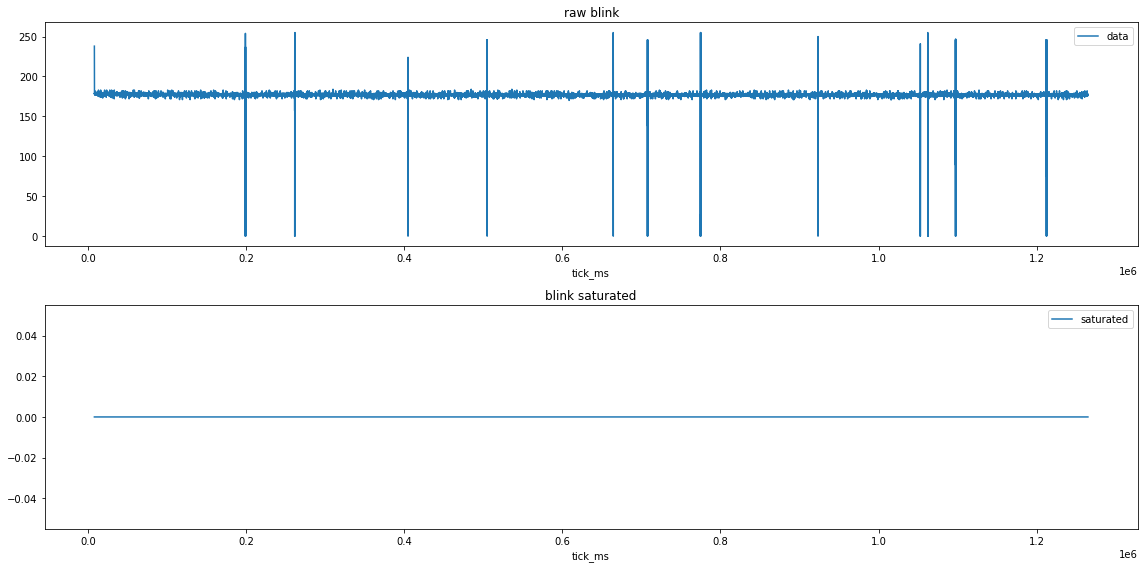

In [9]:
def parseBlinkRow(b):
    packetLength = int(b[6])
    blink_df_row = pd.DataFrame(data=[b[0:12] for i in range(packetLength)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    blink_df_row = pd.concat([blink_df_row, pd.Series(data=b[13:], name='data').astype('int32')], axis=1)
    
    blinkSampleRate = 1000 # 1kHz
    blinkSamplePeriod_ms = 1000 * (1/blinkSampleRate) # 1 ms
    blink_df_row["tick_ms"] = blink_df_row['msFromStart'].astype(int) 
    blink_df_row["tick_ms"] -= (packetLength - np.array(range(1, packetLength+1))) * blinkSamplePeriod_ms
    
    blink_df_row["saturated"] = blink_df_row["res0"].astype(int)
    
    return blink_df_row
    
blinks_df = pd.DataFrame()
for b in blinks:
    blinks_df = pd.concat([blinks_df, parseBlinkRow(b)], axis=0)
blinks_df.reset_index(inplace=True)

fig, ax = plt.subplots(2,1, figsize=(16,8))
blinks_df.plot(x='tick_ms', y='data', ax=ax[0], title='raw blink')
blinks_df.plot(x='tick_ms', y='saturated', ax=ax[1], title='blink saturated')
plt.tight_layout()

## Parse Gyro and Accelerometer

get `acc_df, gyro_df` from `acc, gyro`.  We care about `x, y, z,gyro_df.plot(x='tick_ms', y=['x','y','z'], ax=ax, title='gyro')
 tick_ms`

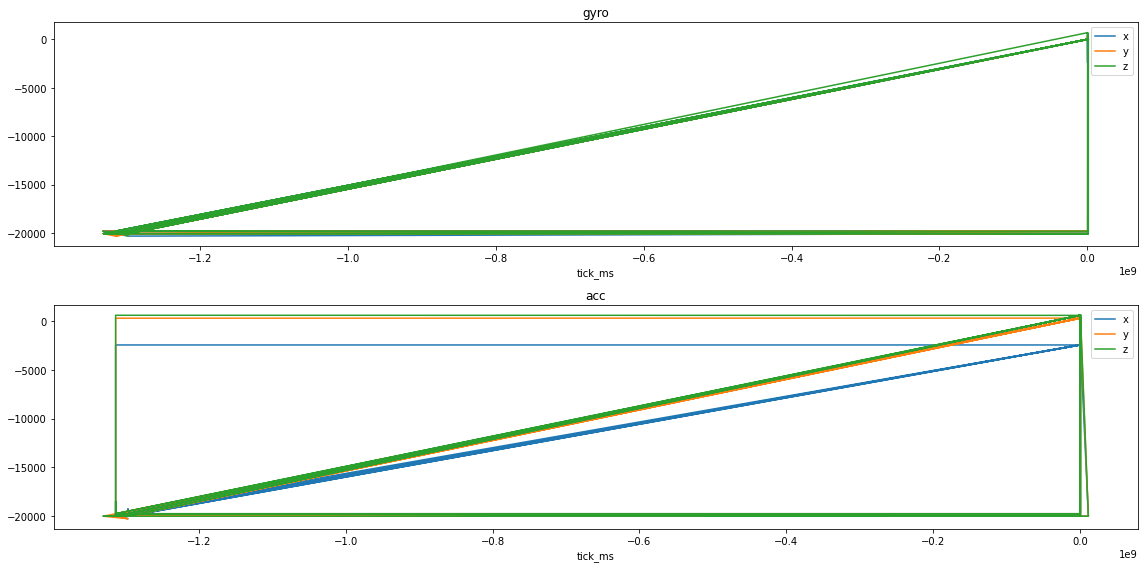

In [10]:
def parseXYZRow(p):
    packetLength = 25
    df_row = pd.DataFrame(data=[p[0:12] for i in range(packetLength)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    df_row = pd.concat([df_row, pd.DataFrame(data=np.array(p[13:]).astype('int32').reshape(-1,5), columns=['x','y','z','imu_tick_ms','tick_ms'])], axis=1)
    return df_row
    
gyro_df = pd.DataFrame()
for g in gyro:
    gyro_df = pd.concat([gyro_df, parseXYZRow(g)], axis=0)    
gyro_df.reset_index(inplace=True)

acc_df = pd.DataFrame()
for a in acc:
    acc_df = pd.concat([acc_df, parseXYZRow(a)], axis=0)    
acc_df.reset_index(inplace=True)

fig, ax = plt.subplots(2,1, figsize=(16,8))
gyro_df.plot(x='tick_ms', y=['x','y','z'], ax=ax[0], title='gyro')
acc_df.plot(x='tick_ms', y=['x','y','z'], ax=ax[1], title='acc')
plt.tight_layout()

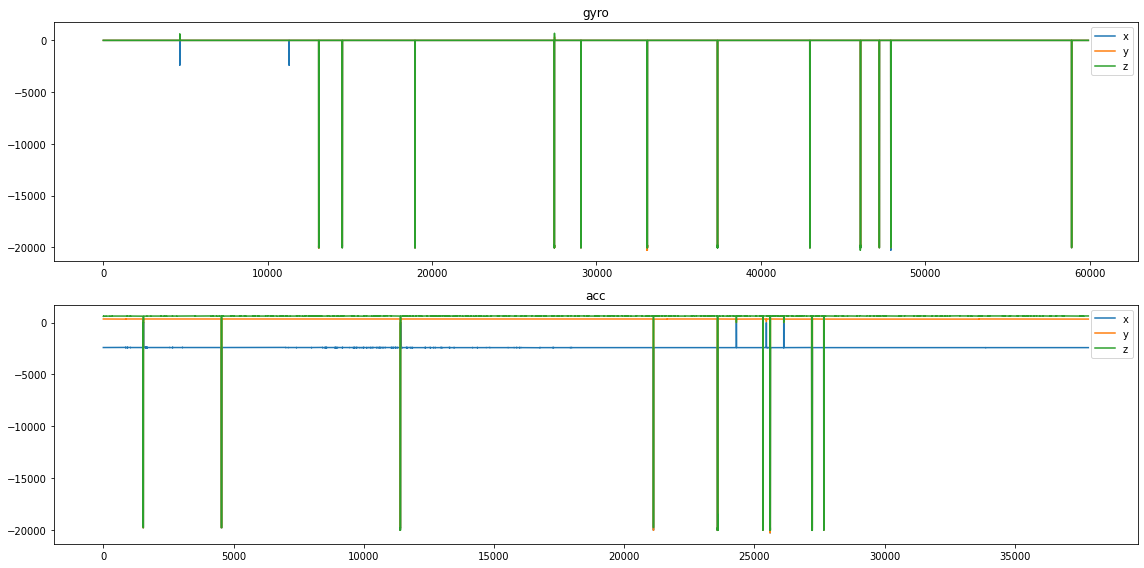

In [14]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
gyro_df.plot( y=['x','y','z'], ax=ax[0], title='gyro')
acc_df.plot( y=['x','y','z'], ax=ax[1], title='acc')
plt.tight_layout()

## Parse Thermal

get `thermal_df` from raw `thermal` values.  We care about `temple_tp, nose_tp, temple_thermistor, nose_thermistor, tick_ms`.  They will be parsed into `nose_temp_C, temple_temp_C, differential_C, and differential_C_rolling`.

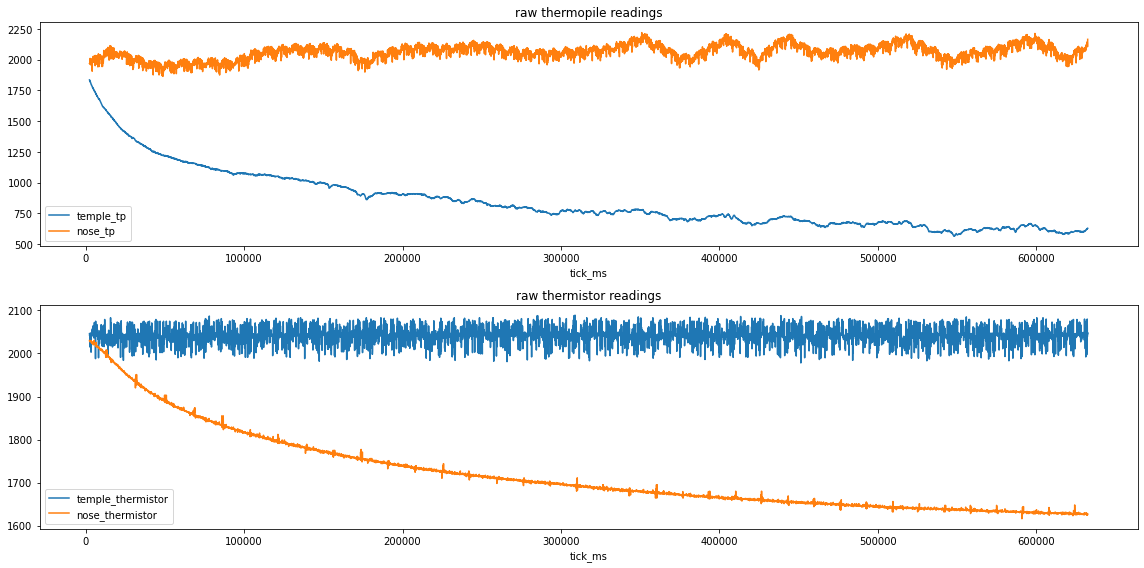

In [11]:
def parseThermalRow(t):
    
    tempSamplePeriod_ms = 100
    numInnerPackets = 4
    rowsInInnerPacket = 5
    # each row has 128 values; 4x 32 value 'packets'; 
    # each 32 has 5 repetitions of 6 values of data + 2 (tick,epoch)
    # these 6 values are interleaved; i.e. the first three are temple numbers, and the first
    # 15 sets of three are temple vals; the second 15 sets of 3 are the corresponding nose vals.
    # to get a timestamped packet, we need [0,1,2] matched with [15,16,17] and so on within each
    # 32 value 'packet'.  
    
    df_row = pd.DataFrame(data=[t[0:12] for i in range(numInnerPackets*rowsInInnerPacket)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    
    payload = np.array(t[13:]).astype(np.int32).reshape(numInnerPackets, -1)
    
    def flatten(t): return [item for sublist in t for item in sublist]
    reindex = flatten([[*range(i*3,i*3+3)] + [*range(15+i*3, 18+i*3)] + [-2,-1] for i in range(rowsInInnerPacket)])
    proper_payload = payload[:,reindex].reshape(-1,8)
    
    df_row = pd.concat([df_row, pd.DataFrame(data=proper_payload, columns=["temple_tp","temple_thermistor","secondary_temple_tick_ms","nose_tp","nose_thermistor","secondary_nose_tick_ms","tick_ms","epoch"])], axis=1)
    df_row['tick_ms'] -= tempSamplePeriod_ms * np.array([4,3,2,1,0] * numInnerPackets)
    
    return df_row
    
thermal_df = pd.DataFrame()
for t in thermal:
    thermal_df = pd.concat([thermal_df, parseThermalRow(t)], axis=0)    
thermal_df.reset_index(inplace=True)

fig, ax = plt.subplots(2,1, figsize=(16,8))
thermal_df.plot(x='tick_ms', y=['temple_tp', 'nose_tp'], ax=ax[0], title='raw thermopile readings')
thermal_df.plot(x='tick_ms', y=['temple_thermistor','nose_thermistor'], ax=ax[1], title='raw thermistor readings')
plt.tight_layout()

In [12]:
def convert_thermistor_to_K(raw_value):
    # STEP 1. Calc R_thermistor value given ADC_val
    R_divider = 100000
    ADC_max = 4095
    
    R_t = (R_divider * raw_value/ADC_max) / (1 - raw_value/ADC_max)
    
    # STEP 2. Convert R_t to temp
    R_0 = 100000
    T_0 = 298.15
    Beta = 3960
    R_inf = R_0 * math.exp(-Beta/T_0)
    
    Temp_K = Beta / np.log(R_t / R_inf)
    return Temp_K
    
def convert_thermopile_to_C(raw_val, T_ref_K, A, a_0, a_1):
    #STEP 1. Calc V_thermopile based on preamp gain and bias
    V_tp = (((raw_val / 4095) * 3.3) - (1.15+0.6084))/1000.0
    
    #STEP 2. Solve for Temperature!
    f_V_tp = (V_tp - a_0) + a_1 * (V_tp - a_0)**2
    T_obj = (T_ref_K**4 + f_V_tp/A)**0.25
    return (T_obj - 273.15)
    
def convert_nose_temp(raw_val, raw_thermistor):
    A   =  7.8e-10
    a_0 = -2.31e-01
    a_1 =  3.61e-03
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)
    
def convert_temple_temp(raw_val, raw_thermistor):
    A   =  4.21e-10
    a_0 = -3.62e-01
    a_1 =  8.31e-02
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)

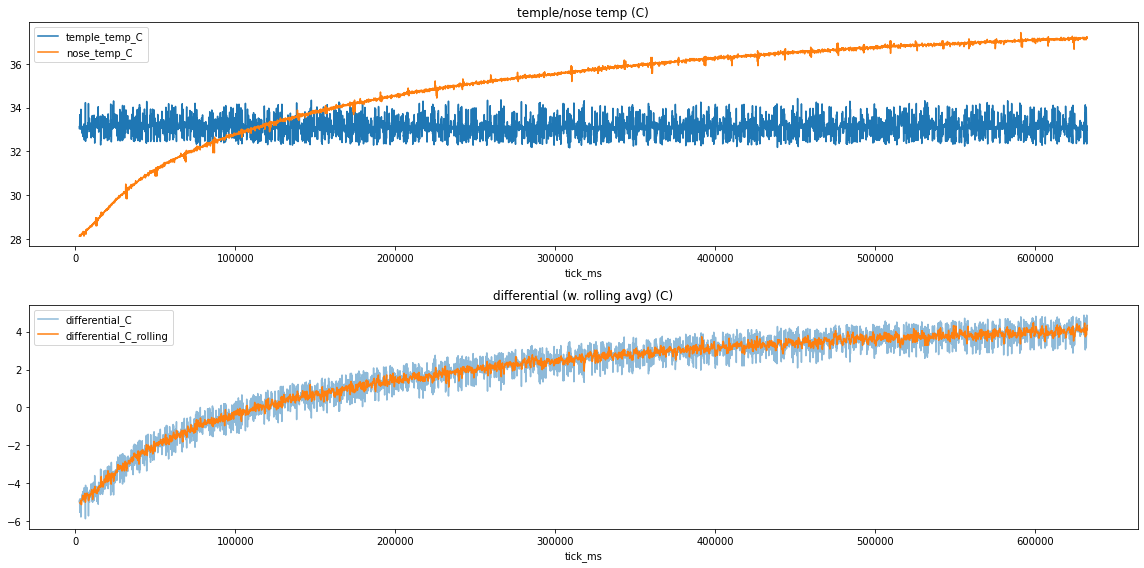

In [13]:
thermal_df['nose_temp_C'] = thermal_df.apply(lambda x: convert_nose_temp(x['nose_tp'], x['nose_thermistor']), axis=1)
thermal_df['temple_temp_C'] = thermal_df.apply(lambda x: convert_temple_temp(x['temple_tp'], x['temple_thermistor']), axis=1)
thermal_df['differential_C'] = thermal_df['nose_temp_C'] - thermal_df['temple_temp_C']
thermal_df['differential_C_rolling'] = thermal_df['differential_C'].rolling(5).mean()

fig, ax = plt.subplots(2,1,figsize=(16,8)) 
thermal_df.plot(x="tick_ms",y=["temple_temp_C","nose_temp_C"], ax=ax[0], title='temple/nose temp (C)')
thermal_df.plot(x="tick_ms",y="differential_C", ax=ax[1], alpha=0.5)
thermal_df.plot(x="tick_ms",y="differential_C_rolling", ax=ax[1], title='differential (w. rolling avg) (C)')
plt.tight_layout()

#'normal' forehead temp is 35.4 - 37.4 C